# CNN implementation sanity checks

In [52]:
import sys, os
sys.path.append(os.path.join(os.path.dirname('.'), '../lib/'))

import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from cs231n.classifiers.cnn import *
from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.solver import Solver



%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
from cs231n.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward

x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

print 'Testing conv_relu_pool'
print 'dx error: ', rel_error(dx_num, dx)
print 'dw error: ', rel_error(dw_num, dw)
print 'db error: ', rel_error(db_num, db)

Testing conv_relu_pool
dx error:  6.12304136821e-09
dw error:  6.47958715396e-10
db error:  1.20349514053e-10


## Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we add regularization this should go up.

In [54]:
model = ThreeLayerConvNet(input_dim=(1, 96, 96), num_filters=32, filter_size=7,
               hidden_dim=100, num_outputs=15, weight_scale=1e-3, reg=0.0,
               dtype=np.float32)

N = 50
X = np.random.randn(N, 1, 96, 96)
y = np.random.randn(N, 15)

loss, grads = model.loss(X, y)
print 'Initial loss (no regularization): ', loss

model.reg = 0.5
loss, grads = model.loss(X, y)
print 'Initial loss (with regularization): ', loss

Initial loss (no regularization):  16.1495319846
Initial loss (with regularization):  789.636531496


## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer.

In [56]:
# Gradient check for l2_loss implementation
num_outputs = 30

x = np.random.randn(num_outputs)
y = np.random.randn(num_outputs)

loss, dx = l2_loss(x, y)

f = lambda _: l2_loss(x, y)[0]
param_grad_num = eval_numerical_gradient(f, x, verbose=False, h=1e-6)
e = rel_error(param_grad_num, dx)
print '%s max relative error: %e' % ('x', e)

assert e < 1e-6, 'L2 Loss function gradient check fail'

x max relative error: 1.189979e-08


In [57]:
# Gradient check for model.loss

num_inputs = 2
input_dim = (1, 16, 16)
reg = 0.0
num_outputs = 30
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randn(num_inputs, num_outputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          num_outputs=num_outputs, loss_fn=l2_loss,
                          dtype=np.float64, weight_scale=1e-2,
                        )
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

W1 max relative error: 1.698534e-07
W2 max relative error: 9.541340e-06
W3 max relative error: 5.798465e-04
b1 max relative error: 2.023035e-07
b2 max relative error: 2.395191e-09
b3 max relative error: 1.328678e-08


## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [60]:
# Load previously cleaned data

import os

np_loaded_data_file = '../data/train_data_cleaned.npz'
if not os.path.isfile(np_loaded_data_file):
    print "%s does not exist. See facial_recog_kaggle.ipynb" % np_loaded_data_file
else:
    print "loading %s" % np_loaded_data_file
    npzfile = np.load(np_loaded_data_file)
    print "loaded: ", npzfile.files
    X_train_clean, y_train_clean = npzfile['X_train_clean'], npzfile['y_train_clean']
    X_train_miss, y_train_miss = npzfile['X_train_miss'], npzfile['y_train_miss']
    feature_labels = npzfile['feature_labels']
    

        
num_train = 200
num_val = 50

rand_idx = np.random.choice(num_train + num_val, num_train + num_val, replace=False)
X_train_small = X_train_clean[rand_idx[:num_train]]
y_train_small = y_train_clean[rand_idx[:num_train]]

X_val_small = X_train_clean[rand_idx[num_train:num_train + num_val]]
y_val_small = y_train_clean[rand_idx[num_train:num_train + num_val]]


loading ../data/train_data_cleaned.npz
loaded:  ['X_train_clean', 'y_train_miss', 'X_train_miss', 'y_train_clean', 'feature_labels']


In [38]:
small_data = {
  'X_train': X_train_small,
  'y_train': y_train_small,
  'X_val': X_val_small,
  'y_val': y_val_small,
}


model = ThreeLayerConvNet(num_filters=16, filter_size=3,
                          loss_fn=l2_loss, 
                          dtype=np.float64, weight_scale=1e-3)

solver = Solver(model, small_data,
                num_epochs=20, batch_size=25,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-4,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 160) loss: 77146.490053
(Epoch 0 / 20) train acc: 1568.487314; val_acc: 1618.843217
(Iteration 2 / 160) loss: 47107.671440
(Iteration 3 / 160) loss: 76371.804542
(Iteration 4 / 160) loss: 27893.463054
(Iteration 5 / 160) loss: 39779.744320
(Iteration 6 / 160) loss: 45612.436019
(Iteration 7 / 160) loss: 41010.183101
(Iteration 8 / 160) loss: 32233.861349
(Epoch 1 / 20) train acc: 901.252272; val_acc: 894.589673
(Iteration 9 / 160) loss: 27145.573397
(Iteration 10 / 160) loss: 22772.223223
(Iteration 11 / 160) loss: 19836.007587
(Iteration 12 / 160) loss: 20380.131992
(Iteration 13 / 160) loss: 23829.214025
(Iteration 14 / 160) loss: 21458.597421
(Iteration 15 / 160) loss: 17649.457107
(Iteration 16 / 160) loss: 18489.341755
(Epoch 2 / 20) train acc: 660.573774; val_acc: 628.839078
(Iteration 17 / 160) loss: 16472.816961
(Iteration 18 / 160) loss: 15785.052369
(Iteration 19 / 160) loss: 12525.275643
(Iteration 20 / 160) loss: 17962.579777
(Iteration 21 / 160) loss: 14783.

(21L, 15L)


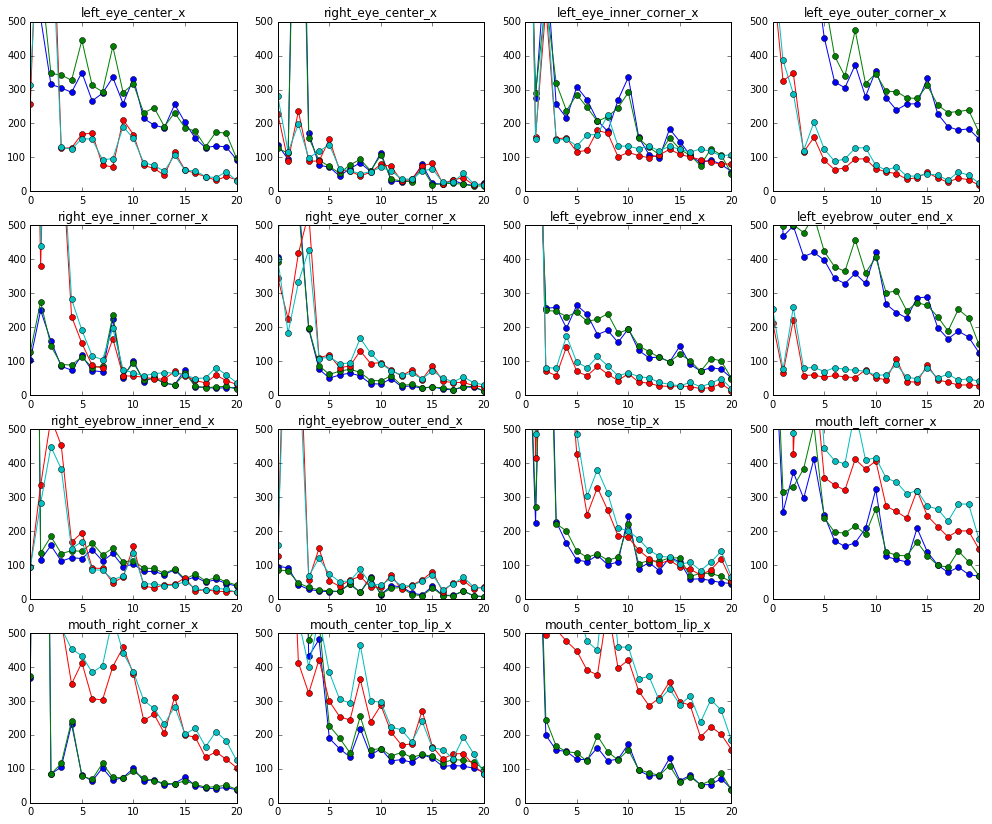

In [62]:
# Visualize the training and validation acc for different features.
train_acc_hist = np.vstack(solver.train_acc_history)
val_acc_hist = np.vstack(solver.val_acc_history)

train_acc_hist_feat_x = train_acc_hist[: , 0::2]
train_acc_hist_feat_y = train_acc_hist[: , 1::2]

val_acc_hist_feat_x = val_acc_hist[: , 0::2]
val_acc_hist_feat_y = val_acc_hist[: , 1::2]

print train_acc_hist_feat_x.shape

num_epochs, num_features = train_acc_hist_feat_x.shape
num_grid_x, num_grid_y = int(np.ceil(np.sqrt(num_features))), int(np.ceil(np.sqrt(num_features)))

feature_labels_x = feature_labels[0::2]

for nx in range(num_grid_x):
    for ny in range(num_grid_y):
        feat_idx = nx * num_grid_y + ny
        if feat_idx >= num_features:
            break
        plt.subplot(num_grid_x, num_grid_y, feat_idx + 1)
        plt.plot(train_acc_hist_feat_x[:, feat_idx], '-o', label='train_x')
        plt.plot(val_acc_hist_feat_x[:, feat_idx], '-o', label='val_x')
        plt.plot(train_acc_hist_feat_y[:, feat_idx], '-o', label='train_y')
        plt.plot(val_acc_hist_feat_y[:, feat_idx], '-o', label='val_y')
        plt.title(feature_labels_x[feat_idx])
        plt.ylim((0,500))
        

plt.gcf().set_size_inches(17, 14)
plt.show()
        